In [1]:
import copy
import itertools
from pprint import pprint

import numpy as np
import torch
import luigi
import dill
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set()
sns.set_context("talk")
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['figure.dpi'] = 140
mpl.rcParams['savefig.dpi'] = 160

from experiment_framework.helpers import load_completed_CCCs_into_dataframe, load_completed_AAs_into_dataframe
from empirical_privacy.row_distributed_svd import \
svd_dataset_settings, ExpCCCSVD, CCCSVD, All
from dataset_utils.recsys_datasets import get_ml1m_user
from dataset_utils.text_datasets import get_twenty_doc

# Looking at asymptotic accuracy

##### If experiments have been completed locally

In [9]:
AAType = 'CCCSVD'
AAs = All(AAType).requires()
DF = load_completed_AAs_into_dataframe(AAs)
n_docs = DF.doc_ind.nunique()
print(n_docs)
cp = sns.color_palette('hls', n_docs)
DF.to_csv('AsymptoticsResults.csv')

5


##### If you just want to look at results

In [16]:
DF = pd.read_csv('AsymptoticsResults.csv')

In [13]:
DF = DF[DF.n_trials_per_training_set_size==DF.n_trials_per_training_set_size.max()]
DF = DF[DF.n_max==DF.n_max.max()]

DF.shape

(30, 17)

In [14]:
DF.sort_values('upper_bound', ascending=False)

,Unnamed: 0,SVD_k,SVD_type,confidence_interval_prob,confidence_interval_width,dataset_name,doc_ind,mean,median,n_bootstraps,n_max,n_trials_per_training_set_size,p,part_fraction,std,upper_bound,validation_set_size
1069,1069,14,hidden_eigs,0.99,0.01,20NG,4,0.940006,0.939783,5757,8192,10,0.99,0.01,0.006452,0.950006,1024
1067,1067,14,hidden_eigs,0.99,0.01,20NG,2,0.581939,0.581830,5757,8192,10,0.99,0.01,0.006520,0.591939,1024
1065,1065,14,hidden_eigs,0.99,0.01,20NG,0,0.580651,0.580596,5757,8192,10,0.99,0.01,0.006337,0.590651,1024
1066,1066,14,hidden_eigs,0.99,0.01,20NG,1,0.578615,0.578474,5757,8192,10,0.99,0.01,0.005197,0.588615,1024
1074,1074,14,hidden_eigs,0.99,0.01,20NG,4,0.575460,0.575487,5757,8192,10,0.99,0.10,0.004894,0.585460,1024
979,979,14,hidden_eigs,0.99,0.01,ml-1m,4,0.574418,0.574439,5757,8192,10,0.99,0.01,0.003804,0.584418,1024
976,976,14,hidden_eigs,0.99,0.01,ml-1m,1,0.550896,0.550887,5757,8192,10,0.99,0.01,0.005146,0.560896,1024
1072,1072,14,hidden_eigs,0.99,0.01,20NG,2,0.535311,0.535417,5757,8192,10,0.99,0.10,0.005402,0.545311,1024
975,975,14,hidden_eigs,0.99,0.01,ml-1m,0,0.528330,0.528321,5757,8192,10,0.99,0.01,0.004027,0.538330,1024
978,978,14,hidden_eigs,0.99,0.01,ml-1m,3,0.521219,0.521123,5757,8192,10,0.99,0.01,0.004069,0.531219,1024


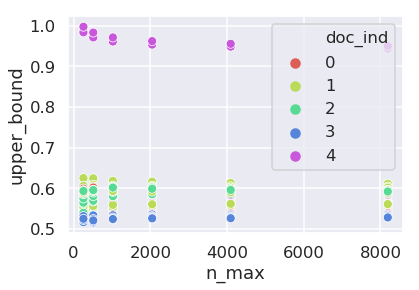

In [17]:
handle = sns.scatterplot(
    data=DF[DF.part_fraction==0.01],
    x='n_max',
    y='upper_bound',
    hue='doc_ind',
    legend='full',
    palette=cp,
   # ci='sd',
   # err_style='band'
)

# Development of asymptotic analysis

### First, focus on a specific dataset and problem setting

In [ ]:
# CCCType = 'ExpCCCSVD' # Expectation
CCCType = 'CCCSVD' # KNN
CCCs = All(CCCType).requires()

In [ ]:
len(CCCs)

###### Load all results

In [ ]:
DF = load_completed_CCCs_into_dataframe(CCCs)
n_docs = DF.doc_ind.nunique()
print(n_docs)
cp = sns.color_palette('hls', n_docs)

##### Pick one curve to model

In [ ]:
subview = {
    'dataset_name': 'ml-1m',
    'doc_ind': 0,
    'part_fraction': 0.1
}
query = ' & '.join(['{k}=={v}'.format(k=k, v=v if type(v) is not str else '"'+v+'"') for k,v in subview.items()])
print(query)
DF = DF.query(query)
del DF['n_max']
del DF['n_trials_per_training_set_size']
DF.drop_duplicates(inplace=True)
DF.dropna(inplace=True)
print(DF.columns)
print(DF.shape)


In [ ]:
for col in DF.columns:
    print(col)
    print(DF[col].unique()[0:11])

In [ ]:
DF[DF.training_set_size==4096]

In [ ]:
DF[DF.training_set_size==8192]

In [ ]:
sns.scatterplot(x='training_set_size', y='classifier_accuracy', data=DF)

### Learning Torch

In [ ]:
x = torch.rand(2,3)
print(x)

In [ ]:
L = [range(i*3, i*3+3) for i in range(4)]
x = torch.tensor(L)
y = np.random.randn(4)
y_tensor = torch.from_numpy(y)
print(y_tensor.size())
print(y_tensor.numpy())


In [ ]:
print(torch.cuda.is_available())

### Applying torch to fit curve

In [ ]:

x = DF.training_set_size.values.astype(np.double)
y = DF.classifier_accuracy.values
x = torch.from_numpy(x)
y = torch.from_numpy(y)
x.requires_grad=False
y.requires_grad=False

In [ ]:
from torch.autograd import Variable

class KNNConvergenceCurve(torch.nn.Module):
    def __init__(self, x, y, d, print_to_console=False):
        super(KNNConvergenceCurve, self).__init__()
        self.m = torch.ones(1, requires_grad=True, dtype=torch.double)
        self.c = torch.ones(1, requires_grad=True, dtype=torch.double)
        self.x = x
        self.y = y
        self.d = d
        self.print_to_console = print_to_console
    
    def predict(self, x):
        return self.m + self.c * 1/(x**(2/(self.d+2)))
    
    def loss(self, x):
        return (self.y - self.predict(x)).pow(2).sum()
    
    def fit(self, learning_rate=0.01, n_iter=500):
        for t in range(n_iter):
            loss = self.loss(self.x)
            loss.backward()
            with torch.no_grad():
                self.m -= learning_rate * self.m.grad
                self.c -= learning_rate * self.c.grad
                self.m.grad.zero_()
                self.c.grad.zero_()
                
    def fit_with_optimizer(self, 
                           learning_rate=0.01,
                           n_iter=500,
                           opt=torch.optim.Adam,
                           loss_fn=torch.nn.MSELoss(reduction='sum')):
        opt = opt([self.m, self.c], lr=learning_rate)
        for t in range(n_iter):
            y_pred = self.predict(x)
            loss = loss_fn(y_pred, self.y)
            if self.print_to_console and t%25==0:
                print(t, loss.item())
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        
    
mod = KNNConvergenceCurve(x,y,6)
print(mod)
print(list(mod.parameters()))

In [ ]:
def plot_fit(mod):
    x = mod.x.numpy()
    y = mod.y.numpy()
    sns.scatterplot(x=x, y=y)
    N = np.logspace(np.log2(np.min(x)), np.log2(np.max(x)*1.05), base=2)
    plt.plot(N, mod.predict(torch.from_numpy(N)).detach().numpy(), '-r')
    plt.plot(N, np.ones_like(N)*mod.m.item(), '--r')
plot_fit(mod)

In [ ]:
mod.fit_with_optimizer()

In [ ]:
print(mod.m, mod.c)
print(mod.m.item())

In [ ]:
plot_fit(mod)

### Use bootstrap to generate confidence interval around asymptotic error

In [ ]:
from sklearn.utils import resample

In [ ]:
def asymptotic_privacy(X, y):
    mod = KNNConvergenceCurve(torch.from_numpy(X), torch.from_numpy(y), 6)
    mod.fit_with_optimizer(n_iter=1500)
    return mod.m.item()

def bootstrap_ci(n_samples, X, y, f):
    res = np.empty((n_samples,))
    for tri in range(n_samples):
        Xi, yi = resample(X.numpy(), y.numpy(), random_state=tri)
        res[tri] = f(Xi, yi)
    return res

bootstrap_asymp = bootstrap_ci(10000, x, y, asymptotic_privacy)

In [ ]:
plt.hist(bootstrap_asymp)

### Hoeffdings Inequality

Suppose $a_i \leq B_i \leq b_i$. Let $c_i=b_i-a_i$ and $C>c_i $ for all $ i$.

$$P[|nE[B]-\sum_{i=1}^n B_i | > t] < 2\exp{\frac{-2t^2}{nC^2}}$$

In [ ]:
def hoeffding_2sided(n, y, C=0.5):
    return 2*np.exp((-2*y**2*n)/(C**2))
def hoeffding_n_given_t_and_p(t=0.005, p=0.999, C=0.5):
    return C**2*np.log(1-p)/(-2*t**2)

N = np.logspace(2,5)
plt.semilogy(N, hoeffding_2sided(N, 0.005))

In [ ]:
hoeffding_n_given_t_and_p(t=0.01, p=0.99)